In [6]:
!pip install optimum
!pip install git+https://github.com/huggingface/transformers.git@72958fcd3c98a7afdc61f953aa58c544ebda2f79
!pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/  # Use cu117 if on CUDA 11.7
#this is required as explained from https://huggingface.co/TheBloke/Mistral-7B-v0.1-GPTQ
!pip install psutil
!pip install --upgrade pandas

import psutil
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import subprocess
import pandas as pd
import threading
import time
import warnings
import os
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/huggingface/transformers.git (to revision 72958fcd3c98a7afdc61f953aa58c544ebda2f79) to /tmp/pip-req-build-1p5qa553
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-1p5qa553
  Running command git rev-parse -q --verify 'sha^72958fcd3c98a7afdc61f953aa58c544ebda2f79'
  Running command git fetch -q https://github.com/huggingface/transformers.git 72958fcd3c98a7afdc61f953aa58c544ebda2f79
  Running command git checkout -q 72958fcd3c98a7afdc61f953aa58c544ebda2f79
  Resolved https://github.com/huggingface/transformers.git to commit 72958fcd3c98a7afdc61f953aa58c544ebda2f79
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... 

In [7]:
import transformers

def print_memory_usage():
    available = psutil.virtual_memory().available / (1024 * 1024 * 1024)  # Convert to GB
    total = psutil.virtual_memory().total / (1024 * 1024 * 1024)  # Convert to GB
    used = psutil.virtual_memory().used / (1024 * 1024 * 1024)  # Convert to GB
    print(f"Total RAM: {total:.2f} GB")
    print(f"Used RAM: {used:.2f} GB")
    print(f"Available RAM: {available:.2f} GB")

print_memory_usage()
print(transformers.__version__)


Total RAM: 251.34 GB
Used RAM: 3.95 GB
Available RAM: 245.63 GB
4.34.0.dev0


In [8]:
!pip install --upgrade auto_gptq
!pip install --upgrade peft
#upgrading these libs solves the issue # "ModuleNotFoundError: No module named 'transformers.models.gemma'"
#But the issue with AttributeError: module peft.tuners.lora has no attribute layer is still not solved.
#Asked on HuggingFace
modelpath="model"
model_cache_dir = "modelCheckpoint"  # Specify your desired directory here
model_name = "TheBloke/Mistral-7B-v0.1-GPTQ"
#device = torch.device("cuda:0")  
torch.cuda.empty_cache()
my_model =AutoModelForCausalLM.from_pretrained(model_name,
                                             device_map="auto",
                                            torch_dtype=torch.float16,
                                             trust_remote_code=False,
                                             revision="main")
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
#revision is from which branch you should pull here it is from the main. There are different branches for the different variants
print_memory_usage()

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


AttributeError: module peft.tuners.lora has no attribute layer

<s> from typing import List   def has_close_elements(numbers: List[float], threshold: float) -> bool: """ Check if in given list of numbers, are any two numbers closer to each other than given threshold.  >>> has_close_elements([1.0, 2.0, 3.0], 0.5)   False     >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)     True     """  for i in range(len(numbers)-1):    if abs(numbers[i] - numbers[i+1]) < threshold:      return True  return False</s>
<s> def truncate_number(number: float) -> float: """ Given a positive floating point number, it can be decomposed into and integer part (largest integer smaller than given number) and decimals (leftover part always smaller than 1). Return the decimal part of the number. >>> truncate_number(3.5)     0.5  """  return number % 1

def calculate_average(numbers: list) -> float: """ Given a list of numbers, return the average of all of them. >>> calculate_average([1, 2, 3])     2.0 """  return sum(numbers) / len(numbers)

def calculate_perimet

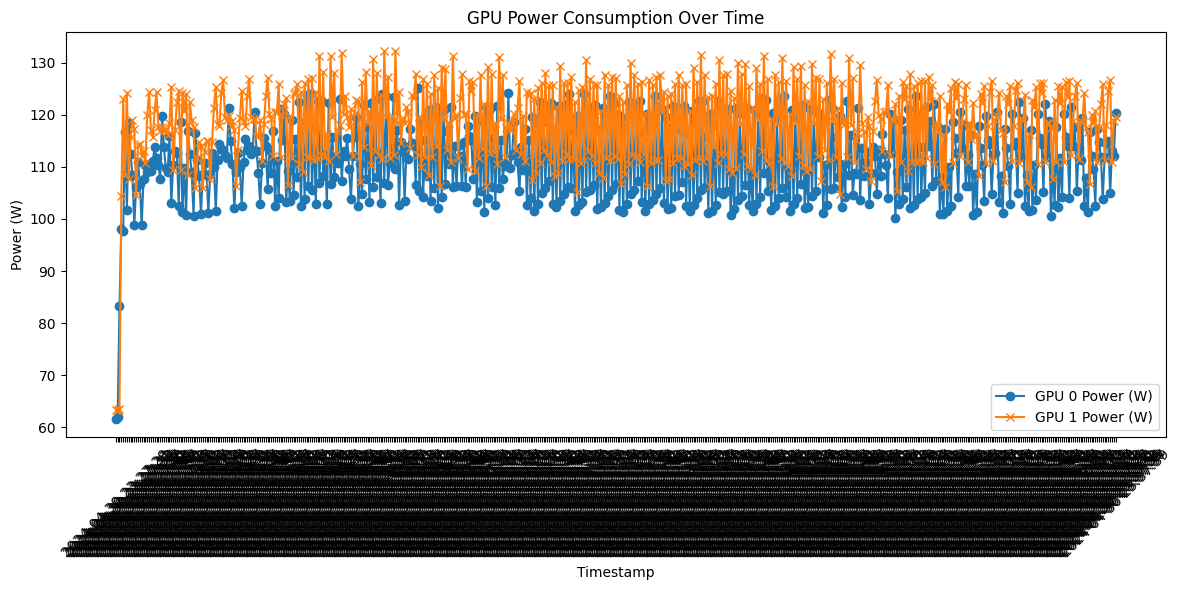

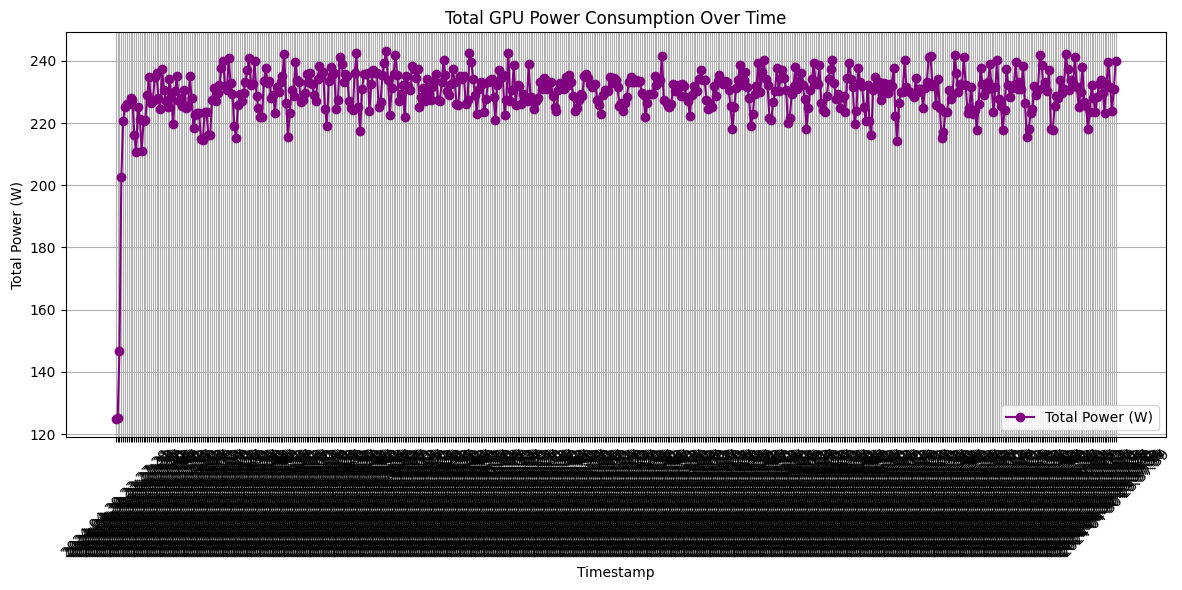

Monitoring stopped. CSV file should be generated with real GPU power usage values.


In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings('ignore')

# Placeholder for global flag to control the background monitoring
keep_monitoring = True

def fetch_gpu_power():
    """Fetch the current power usage of GPUs using nvidia-smi."""
    # The command to fetch power usage
    cmd = "nvidia-smi --query-gpu=power.draw --format=csv,noheader,nounits"
    power_draw_str = subprocess.check_output(cmd, shell=True).decode('utf-8').strip().split('\n')
    # Convert power draw strings to floats
    power_draw = [float(x) for x in power_draw_str]
    return power_draw

def monitor_gpu_energy_usage(output_csv="gpu_energy_usage.csv"):
    readings = []
    
    while keep_monitoring:
        # Fetch real energy readings for the GPUs
        gpu_power = fetch_gpu_power()
        gpu_0_power = gpu_power[0] if len(gpu_power) > 0 else 0
        gpu_1_power = gpu_power[1] if len(gpu_power) > 1 else 0
        
        # Get the current timestamp
        now = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
        
        # Append new reading to the list
        readings.append([now, gpu_0_power, gpu_1_power])
        
        # Wait a bit before the next measurement
        time.sleep(1)  # Adjust the frequency of measurements as needed

    # Once monitoring is done, create a DataFrame and save to CSV
    df = pd.DataFrame(readings, columns=["Timestamp", "GPU_0_Power_W", "GPU_1_Power_W"])
    # Calculate the total power for each row
    df['Total_Power_W'] = df['GPU_0_Power_W'] + df['GPU_1_Power_W']
    # Calculate the average power for each row
    df['Average_Power_W'] = (df['GPU_0_Power_W'] + df['GPU_1_Power_W']) / 2
    # Time interval in hours
    time_interval_hours = 1 / 3600

    # Calculate energy for each GPU in watt-hours (Wh)
    df['GPU_0_Energy_Wh'] = df['GPU_0_Power_W'] * time_interval_hours
    df['GPU_1_Energy_Wh'] = df['GPU_1_Power_W'] * time_interval_hours
    # If you want a running total of energy consumption, you can do a cumulative sum
    df['GPU_0_Energy_Wh_Cumulative'] = df['GPU_0_Energy_Wh'].cumsum()
    df['GPU_1_Energy_Wh_Cumulative'] = df['GPU_1_Energy_Wh'].cumsum()

    # Assuming df['Timestamp'] is already in a suitable format for plotting; if not, you may need to convert it
    # Plot GPU_0 Power
    plt.figure(figsize=(12, 6))
    plt.plot(df['Timestamp'], df['GPU_0_Power_W'], label='GPU 0 Power (W)', marker='o')

    # Plot GPU_1 Power
    plt.plot(df['Timestamp'], df['GPU_1_Power_W'], label='GPU 1 Power (W)', marker='x')

    # Adding titles and labels
    plt.title('GPU Power Consumption Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Power (W)')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()
    # Plotting Total Power Consumption in Wh
    plt.figure(figsize=(12, 6))
    plt.plot(df['Timestamp'], df['Total_Power_W'], label='Total Power (W)', marker='o', linestyle='-', color='purple')
    plt.title('Total GPU Power Consumption Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Total Power (W)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()  # Display the second plot
    df.to_csv(output_csv, index=False)

# Start monitoring in a background thread
monitor_thread = threading.Thread(target=monitor_gpu_energy_usage, args=("gpu_energy_usage3.csv",))
monitor_thread.start()

# Example main task placeholder
try:
    input_text = 'from typing import List   def has_close_elements(numbers: List[float], threshold: float) -> bool: """ Check if in given list of numbers, are any two numbers closer to each other than given threshold.  >>> has_close_elements([1.0, 2.0, 3.0], 0.5)   False     >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)     True     """ '
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    input_ids = input_ids.to("cuda")
    output = my_model.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=512)
    print(tokenizer.decode(output[0]))
    input_text = 'def truncate_number(number: float) -> float: """ Given a positive floating point number, it can be decomposed into and integer part (largest integer smaller than given number) and decimals (leftover part always smaller than 1). Return the decimal part of the number. >>> truncate_number(3.5)     0.5  """ '
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    input_ids = input_ids.to("cuda")
    output = my_model.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=512)
    print(tokenizer.decode(output[0]))
    input_text =' from typing import List def below_zero(operations: List[int]) -> bool:""" You\'re given a list of deposit and withdrawal operations on a bank account that starts with zero balance. Your task is to detect if at any point the balance of account fallls below zero, and at that point function should return True. Otherwise it should return False. >>> below_zero([1, 2, 3]) False  >>> below_zero([1, 2, -4, 5]) True""" '
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    input_ids = input_ids.to("cuda")
    output = my_model.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=512)
    print(tokenizer.decode(output[0]))
    input_text ='from typing import List   def mean_absolute_deviation(numbers: List[float]) -> float:""" For a given list of input numbers, calculate Mean Absolute Deviation  around the mean of this dataset. Mean Absolute Deviation is the average absolute difference between each   element and a centerpoint (mean in this case): MAD = average | x - x_mean | >>> mean_absolute_deviation([1.0, 2.0, 3.0, 4.0])  1.0"""'
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    input_ids = input_ids.to("cuda")
    output = my_model.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=512)
    print(tokenizer.decode(output[0]))
    input_text='from typing import List   def intersperse(numbers: List[int], delimeter: int) -> List[int]:""" Insert a number \'delimeter\' between every two consecutive elements of input list `numbers\'     >>> intersperse([], 4)  []     >>> intersperse([1, 2, 3], 4)  [1, 4, 2, 4, 3] """'
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    input_ids = input_ids.to("cuda")
    output = my_model.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=512)
    print(tokenizer.decode(output[0]))
    


finally:
    # Ensure the monitoring stops when the main task is done
    keep_monitoring = False
    monitor_thread.join()

print("Monitoring stopped. CSV file should be generated with real GPU power usage values.")